<a href="https://colab.research.google.com/github/kasvinatirumal/wdrp_wi25/blob/main/Analysis_of_Call_Option_Pricing%2C_Drift_and_Volatility_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Option Pricing for the Top 5 S&P 500 Stocks

Research Questions:
1. Does the volatility smile exist in real-world markets, and how does its curviness change with different times to expiration? Under what market conditions is the volatility smile most pronounced?
1. What would the price of each call option be under risk-neutral valuation, and how does it differ from its actual market price?

In [1]:
pip install yahoo_fin

In [2]:
from yahoo_fin import options
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import math
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [3]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Loading & Preparation

In [4]:
# # creates a Ticker object for the top 5 S&P 500 Companies
# aapl = yf.Ticker("AAPL") # Apple
# nvda = yf.Ticker("NVDA") # NVIDIA
# msft = yf.Ticker("MSFT") # Microsoft
# amzn = yf.Ticker("AMZN") # Amazon
# meta = yf.Ticker("META") # Meta

# # gets expiration_dates for options
# exp_dates = aapl.options

# date_six_month_ltr = datetime.today().replace(month=(datetime.today().month + 6) % 12)
# exp_date = next(date for date in exp_dates if date >= date_six_month_ltr.strftime("%Y-%m-%d"))
# print(f"Expiration Date: {exp_date}")

In [5]:
# stocks = ["AAPL", "NVDA", "MSFT", "AMZN", "META"]
# calls_df = options.get_calls("AAPL", exp_date)

# for stock in stocks[1:]:
#     df = options.get_calls(stock, exp_date)
#     calls_df = pd.concat([calls_df, df])

In [6]:
# calls_df["Trade Date"] = pd.to_datetime(calls_df["Last Trade Date (EST)"], format="%m/%d/%Y %I:%M %p").dt.date
# calls_df["Months to Exp"] = ((pd.to_datetime(exp_date) - pd.to_datetime(calls_df["Trade Date"])).dt.days / 30).astype(int)
# calls_df["Implied Volatility"] = calls_df["Implied Volatility"].str[:-1].astype(float)/100
# calls_df = calls_df[calls_df["Implied Volatility"] != 0]

In [7]:
# calls_df = calls_df.reset_index().drop(columns=["index", "Last Trade Date (EST)", "Change", "% Change", "Volume", "Open Interest"])
# calls_df.to_csv("call_options.csv", index=False)

In [8]:
calls_df = pd.read_csv("call_options.csv")
calls_df.sample(n=10)

,Contract Name,Strike,Last Price,Bid,Ask,Implied Volatility,Trade Date,Months to Exp
374,META250919C00350000,350,349.35,325.45,327.90,0.7323,2025-01-31,7
126,NVDA250919C00126000,126,15.00,14.55,14.65,0.5460,2025-03-03,6
388,META250919C00420000,420,311.45,259.80,262.25,0.6110,2025-02-18,7
0,AAPL250919C00005000,5,243.10,236.65,237.50,3.3330,2025-02-24,6
515,META250919C01260000,1260,1.00,0.94,1.03,0.3826,2025-02-24,6
500,META250919C01110000,1110,7.10,2.57,2.68,0.3699,2025-02-14,7
83,NVDA250919C00055000,55,84.92,63.75,64.35,0.9049,2025-02-24,6
159,NVDA250919C00190000,190,2.75,2.69,2.73,0.5242,2025-03-03,6
410,META250919C00530000,530,151.85,165.75,167.65,0.4949,2025-02-25,6
302,AMZN250919C00165000,165,53.30,52.25,52.80,0.4838,2025-03-03,6


In [9]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Contract Name       526 non-null    object 
 1   Strike              526 non-null    int64  
 2   Last Price          526 non-null    float64
 3   Bid                 526 non-null    float64
 4   Ask                 526 non-null    float64
 5   Implied Volatility  526 non-null    float64
 6   Trade Date          526 non-null    object 
 7   Months to Exp       526 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 33.0+ KB


In [10]:
calls_df.describe()

,Strike,Last Price,Bid,Ask,Implied Volatility,Months to Exp
count,526.000000,526.000000,526.000000,526.000000,526.000000,526.000000
mean,458.557034,83.892091,82.288764,83.039297,0.712993,6.532319
std,455.381807,123.188974,122.748048,123.584507,0.815230,1.676135
min,5.000000,0.090000,0.060000,0.110000,0.226600,6.000000
25%,155.250000,4.000000,3.300000,3.387500,0.366950,6.000000
50%,295.000000,32.480000,31.675000,31.950000,0.505300,6.000000
75%,613.750000,102.800000,97.212500,98.012500,0.651100,6.000000
max,2500.000000,659.000000,647.650000,651.650000,5.582400,15.000000


### RQ1: Does the volatility smile exist in real-world markets, and how does its curviness change with different times to expiration? Under what market conditions is the volatility smile most pronounced?

In [11]:
calls_df["Months to Exp"].value_counts()

,count
Months to Exp,
6,410
7,82
15,18
8,12
9,4


In [12]:
# remove options that expire in 9 months since that group only has 4 observations
calls_df_plot = calls_df[calls_df["Months to Exp"] != 9]
groups = calls_df_plot.groupby("Months to Exp")

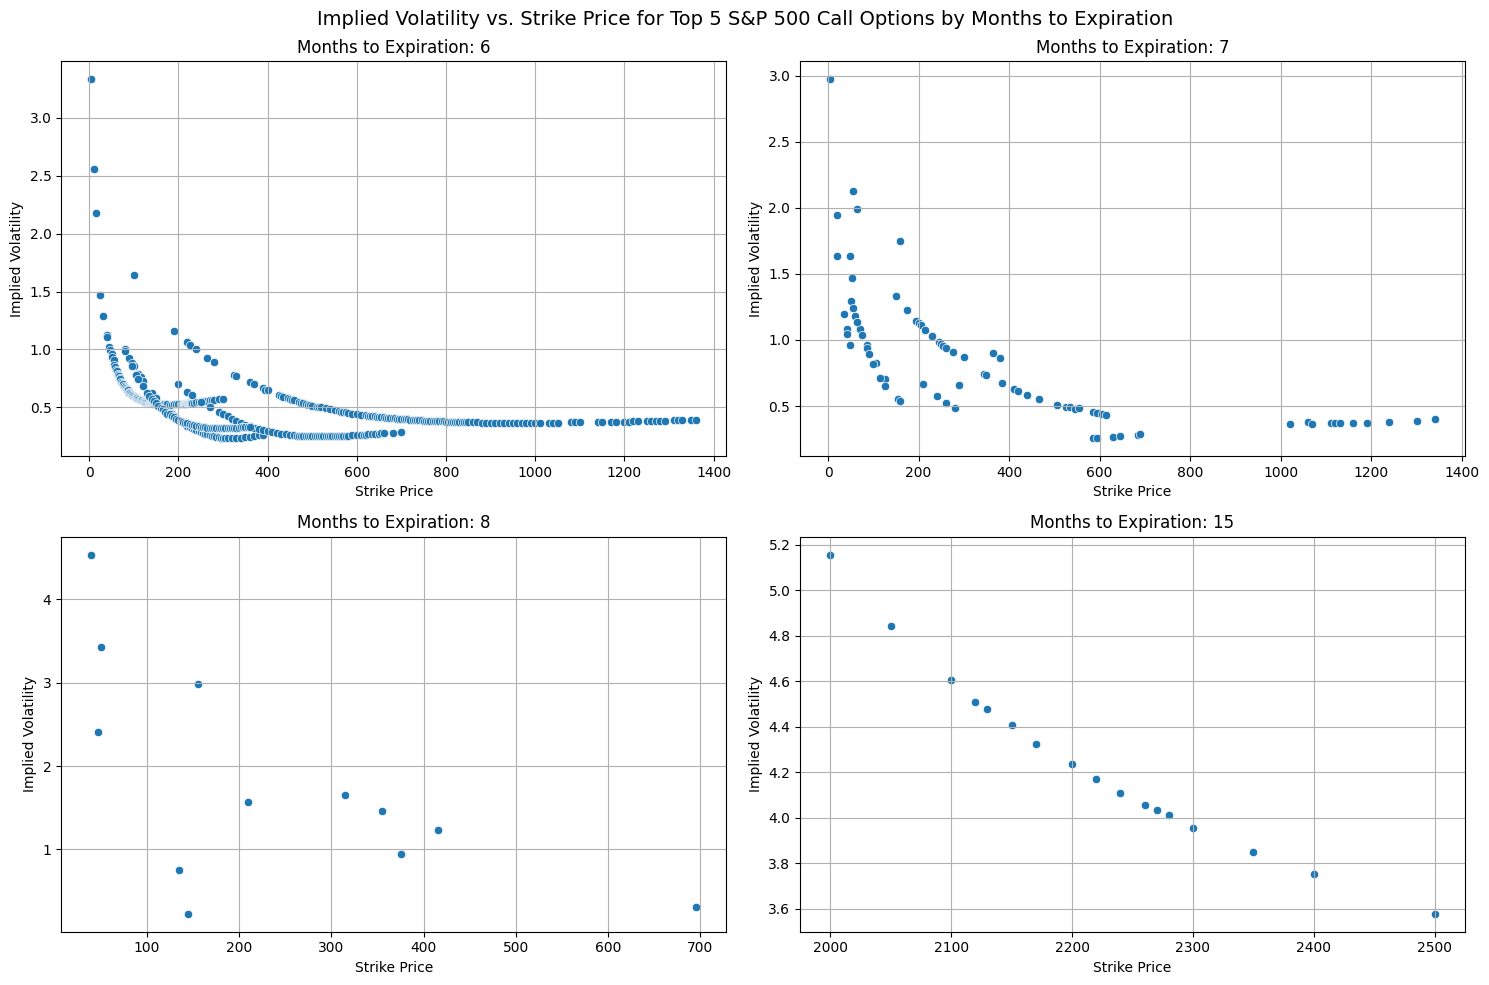

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Implied Volatility vs. Strike Price for Top 5 S&P 500 Call Options by Months to Expiration", fontsize=14)

axes = axes.flatten()
for ax, (month, group) in zip(axes, groups):
    if month == 15:
        group = group.iloc[1:]  # remove outlier to zoom into the visual
    sns.scatterplot(ax=ax, x="Strike", y="Implied Volatility", data=group)
    ax.set_title(f"Months to Expiration: {month}")
    ax.set_xlabel("Strike Price")
    ax.set_ylabel("Implied Volatility")
    ax.grid(True)
plt.tight_layout()

Observations:
1. The shape of all four plots resemble the first half of a volatility smile.
2. As time to expiration increases, the shape of the scatterplot becomes less curvy, and more linear.









### RQ2: What would the price of each call option be under risk-neutral valuation, and how does it differ from its actual market price?

The formula for risk-neutral valuation for European call options is known as **Black-Scholes Formula**, which states: The price of a European Call Option wth strike price $K$ and time of maturity $T$ is given by the formula $\Pi(t) = F(t, S(t))$, where: \\

$$F =  S \cdot N[d_1(t, s)] - e^{−r(T-t)} \cdot K \cdot N[d_2(t, s)]$$

$N$ is the cumulative distribution function for the $N[0,1]$ distribution, and: \\
\begin{align*}
d_1(t, s) &= \frac{1}{\sigma \cdot \sqrt{T-t}} \cdot \left[ln\left(\frac{S}{K}\right) + \left(r + \frac{1}{2}\sigma^2\right) \cdot (T-t)\right]\\
\\
d_2(t, s) &= d_1(t, s) - \sigma \cdot \sqrt{T-t}
\end{align*}

The variables above are as follows:
- $K$: Strike price in US dollars
- $S$: Stock price in US dollars
- $T-t$: Time to expiration in number of years
- $r$: Risk-free rate (based on return on US treasury bills)
- $\sigma$: Implied volatility
- $F$: Final price of option

Using the above formula, we calculate the theorectical price for each call option in the dataset `calls_df`

In [14]:
def calc_call_option_price(S, K, T, r, v):
  d1 = (math.log(S/K) + (r + 0.5 * v**2) * T) / (v * math.sqrt(T))
  d2 = d1 - v * math.sqrt(T)
  F = S * norm.cdf(d1) - math.exp(-r * T) * K * norm.cdf(d2)
  return F

In [15]:
def get_monthly_stock_data(ticker, trade_date):
    year_month = trade_date.strftime("%Y-%m")

    # Download monthly stock data
    stock_data = yf.download(ticker, start=f'{year_month}-01', end=f'{year_month}-28', interval='1mo', progress=False, auto_adjust=True)

    if not stock_data.empty:
        return stock_data["Close"].iloc[-1]  # Last trading day of the month
    else:
        return None

In [16]:
calls_df["Trade Date"] = pd.to_datetime(calls_df["Trade Date"])
stock_prices = []
for index, row in calls_df.iterrows():
    ticker = row["Contract Name"][:4] # gets first 4 characters
    trade_date = row["Trade Date"]

    price = get_monthly_stock_data(ticker, trade_date)[ticker]
    stock_prices.append(price)

calls_df["Stock Price"] = stock_prices.copy()

Continuous rate of interest calculation:

We choose the discrete r to be 0.0434 since that is the current return rate of a 6-month treasury bill. Since we assume a constant time to expiration of 6 months, $t=\frac{6}{12} =\frac{1}{2}\text{years}$.

\begin{align*}
e^{r_{cont} t} &= 1 + r_{discrete} \\
e^{\frac{r_{cont}}{2}} &= 1 + r_{discrete} \\
r_{cont} &= 2\ln\left(1+\frac{r_{discrete}}{2}\right)
\end{align*}



In [17]:
# calculating a continous rate of interest, based on the available discrete rate
r_discrete = 0.0434
r_cont = 2 * math.log(1+r_discrete/2)

In [18]:
calls_df["Risk Neutral Price"] = calls_df.apply(
    lambda row: calc_call_option_price(row["Stock Price"], row["Strike"], row["Months to Exp"] / 12, r_cont, row["Implied Volatility"]), axis=1
)
calls_df["Market Price"] = (calls_df["Bid"] + calls_df["Ask"]) / 2
calls_df["Difference"] = calls_df["Risk Neutral Price"] - calls_df["Market Price"]

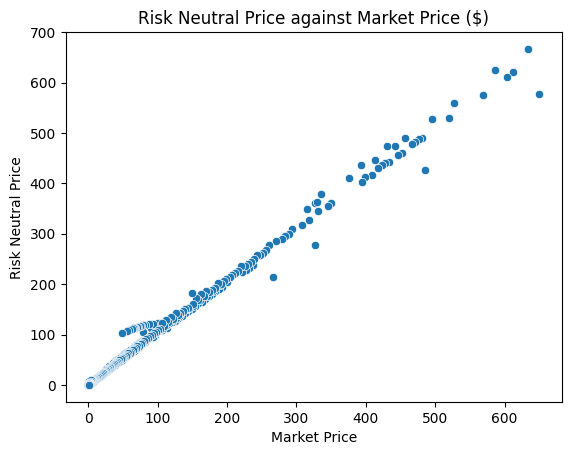

In [19]:
sns.scatterplot(x="Market Price", y="Risk Neutral Price", data=calls_df)
plt.title("Risk Neutral Price against Market Price ($)");

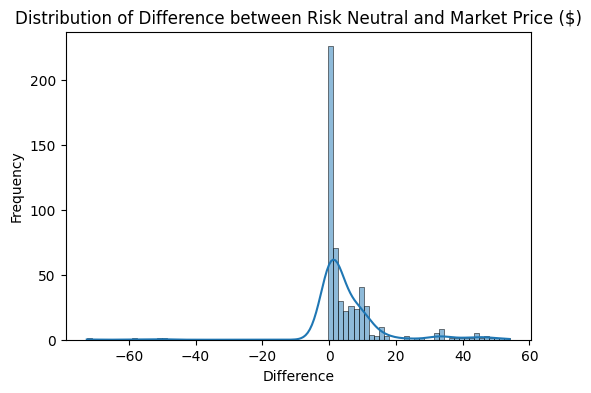

In [20]:
plt.figure(figsize=(6, 4))
sns.histplot(calls_df["Difference"], binwidth=1.5, kde=True)
plt.title("Distribution of Difference between Risk Neutral and Market Price ($)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show()

In [21]:
# Creates a new column Price Valuation that categorizes whether the option
# was overpriced or underpriced relative to its risk neutral valuation
calls_df["Price Valuation"] = np.where(
    calls_df["Difference"] > 0, "Underpriced",
    np.where(
        calls_df["Difference"] < 0, "Overpriced", "Fairly Priced"
    )
)

In [22]:
def median_diff_by_col(df, col):
  unique_cat = calls_df[col].value_counts()
  median_diff = calls_df.groupby(col)["Difference"].median()
  median_diff_by_cat = pd.DataFrame({
      'Count': unique_cat,
      'Median Difference($)': median_diff
  })
  return median_diff_by_cat


md_price_val = median_diff_by_col(calls_df, "Price Valuation")

In [23]:
total = md_price_val["Count"].sum()
md_price_val["Percentage (%)"] = md_price_val["Count"] / total * 100
md_price_val

,Count,Median Difference($),Percentage (%)
Price Valuation,,,
Overpriced,39,-0.057163,7.414449
Underpriced,487,2.226359,92.585551


Most call options were underpriced compared to its risk neutral price.

In [24]:
md_months = median_diff_by_col(calls_df, "Months to Exp")
md_months

,Count,Median Difference($)
Months to Exp,,
6,410,1.079571
7,82,8.788056
8,12,10.821535
9,4,14.554100
15,18,44.371946


As the time to expiration increases, the deviation between risk-neutral price and market price also increases.

# Estimating Drift and Historic Volatility of Microsoft Stock in 2024

In [25]:
ticker = "MSFT"
msft_info = yf.download(ticker, start="2024-01-01", end="2024-12-31", progress=False)
msft_price = msft_info['Close'].reset_index()
msft_price.columns = ['Date', 'Close']
print(f"Number of Trading Days:{len(msft_price)}")

YF.download() has changed argument auto_adjust default to True
Number of Trading Days:251


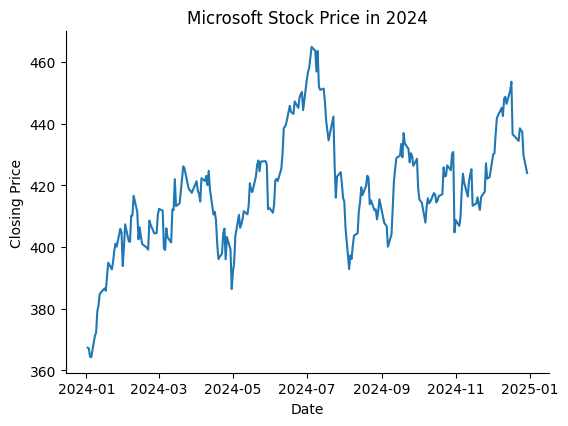

In [26]:
# Visualize Mircrosft Stock Price Movement
plot = sns.relplot(data=msft_price, x="Date", y="Close", kind="line")
plot.set(ylabel="Closing Price", title="Microsoft Stock Price in 2024");
plot.fig.set_size_inches(6, 4)

We will use the **Geometric Brownian Motion (GBM)** model to represent the stochastic process of stock prices as seen above. \
Under this model, let $X_t$ denote our stock price at time $t$, and the process $Z_t$ be defined as follows: $Z_t = ln(X_t)$.

The process $Z_t$ follows a normal distribution with the following properties:
$$
Z_{\frac{i+1}{251}} - Z_{\frac{i}{251}} \sim N \left(\alpha_{\text{annual}} - \frac{1}{2}\left(\frac{\sigma_{\text{annual}}^2}{251}\right), \ \frac{\sigma_{\text{annual}}^2}{251} \right)
$$
where $\alpha_{\text{annual}}$ is the **annualized drift**, whereas $\sigma_{\text{annual}}$ is the **annualized volatility**.

We use 251 days instead of 365 days, since we only had 251 trading days in 2024.


In [27]:
msft_price['log_returns'] = np.log(msft_price['Close']) - np.log(msft_price['Close'].shift(1))
msft_price

,Date,Close,log_returns
0,2024-01-02,367.380615,NaN
1,2024-01-03,367.113159,-0.000728
2,2024-01-04,364.478149,-0.007204
3,2024-01-05,364.289978,-0.000516
4,2024-01-08,371.164673,0.018696
...,...,...,...
246,2024-12-23,434.379028,-0.003097
247,2024-12-24,438.450836,0.009330
248,2024-12-26,437.233276,-0.002781
249,2024-12-27,429.668457,-0.017453


\begin{align*}
\alpha_{\text{annual}} &= \alpha_{\text{daily}} + \frac{1}{2}\left(\frac{\sigma_{\text{daily}}^2}{251} \right) \\
\sigma_{\text{annual}} &= \sigma_{\text{daily}}\sqrt{251}
\end{align*}

In [28]:
drift_daily = msft_price["log_returns"].mean()
vol_daily = msft_price["log_returns"].std()

annual_drift = drift_daily + (0.5 * vol_daily**2) / 251
annual_vol = vol_daily * np.sqrt(251)

print("Estimated Annualized Values for 2024:")
print(f"Drift (Expected Return): {annual_drift}")
print(f"Historic Volatility: {annual_vol}")

Estimated Annualized Values for 2024:
Drift (Expected Return): 0.0005734688414415471
Historic Volatility: 0.2003846731542627
